In [1]:
import nltk
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk

In [4]:
# global parameters for plots
plt.style.use("seaborn-v0_8-white")
plt.rcParams['figure.dpi'] = 300
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams['font.size'] = 8
def save_figure(fig, fig_name):
    fig.savefig("../figures/" + fig_name + ".tiff")
    fig.savefig("../figures/" + fig_name + ".png")

In [5]:
# load the dataset
coins = pd.read_parquet("../data/coins_df.parquet")

In [6]:
coins.head(5)

,@id,@type,ontology#hasAuthority,ontology#hasDenomination,ontology#hasEndDate,ontology#hasManufacture,ontology#hasMaterial,ontology#hasMint,@id_obverse,ontology#hasRegion,...,ontology#hasIssuer,ontology#hasLegend_obverse,ontology#hasPortrait_obverse,description_obverse,ontology#hasLegend_reverse,ontology#hasPortrait_reverse,description_reverse,ontology#hasControlmark_reverse,not_before,not_after
0,http://numismatics.org/ocre/id/ric.6.sis.221,"[http://www.w3.org/2004/02/skos/core#Concept, ...",licinius,ae2,0311-01-01,struck,ae,siscia,ric.6.sis.221#obverse,pannonia,...,,DIVO GAL VAL MAXIMIANO,galerius,"Head of Galerius, veiled, right",FORTI FOR-TVNAE,58260,"Fortuna, draped, standing left by wheel, holdi...",None,311.0,311.0
1,http://numismatics.org/ocre/id/ric.4.ph_i.28A,"[http://www.w3.org/2004/02/skos/core#Concept, ...",philip_the_arab,aureus,0247-01-01,struck,av,rome,ric.4.ph_i.28A#obverse,italy,...,,IMP M IVL PHILIPPVS AVG,philip_the_arab,"Bust of Philip the Arab, laureate, draped, cui...",ANNONA AVGG,nomisma.rdf,"Annona, draped, standing left, holding corn-ea...",None,244.0,247.0
2,http://numismatics.org/ocre/id/ric.9.tri.96B.2,"[http://nomisma.org/ontology#TypeSeriesItem, h...",valentinian_ii,ae3,0392-01-01,struck,ae,treveri,ric.9.tri.96B.2#obverse,gallia,...,,D N THEODO-SIVS P F AVG,theodosius_i,"Bust of Theodosius I, pearl-diademed, draped a...",GLORIA RO-MANORVM,,"Emperor advancing right, dragging captive with...",None,388.0,392.0
3,http://numismatics.org/ocre/id/ric.8.aq.3,"[http://www.w3.org/2004/02/skos/core#Concept, ...",constantine_ii,multiple-gold,0340-01-01,struck,av,aquileia,ric.8.aq.3#obverse,italy,...,,FL IVL CONS-TANS P F AVG,constans,"Bust of Constans, laureate, rosette-diademed, ...",VIRTVS - CONSTANTIS AVG,constans,"Constans, draped, cuirassed, standing front, h...",None,337.0,340.0
4,http://numismatics.org/ocre/id/ric.4.crl.191,"[http://www.w3.org/2004/02/skos/core#Concept, ...",caracalla,denarius,0211-01-01,struck,ar,rome,ric.4.crl.191#obverse,italy,...,,ANTONINVS PIVS AVG BRIT,caracalla,"Head of Caracalla, laureate, right",PONTIF TR P XIIII COS III,80685,"Virtus, helmeted, draped, standing right, left...",None,211.0,211.0


In [7]:
duration = coins.apply(lambda row: row["not_after"] - row["not_before"] + 1, axis=1)
duration[:10]

0    1.0
1    4.0
2    5.0
3    4.0
4    1.0
5    1.0
6    2.0
7    8.0
8    2.0
9    6.0
dtype: float64

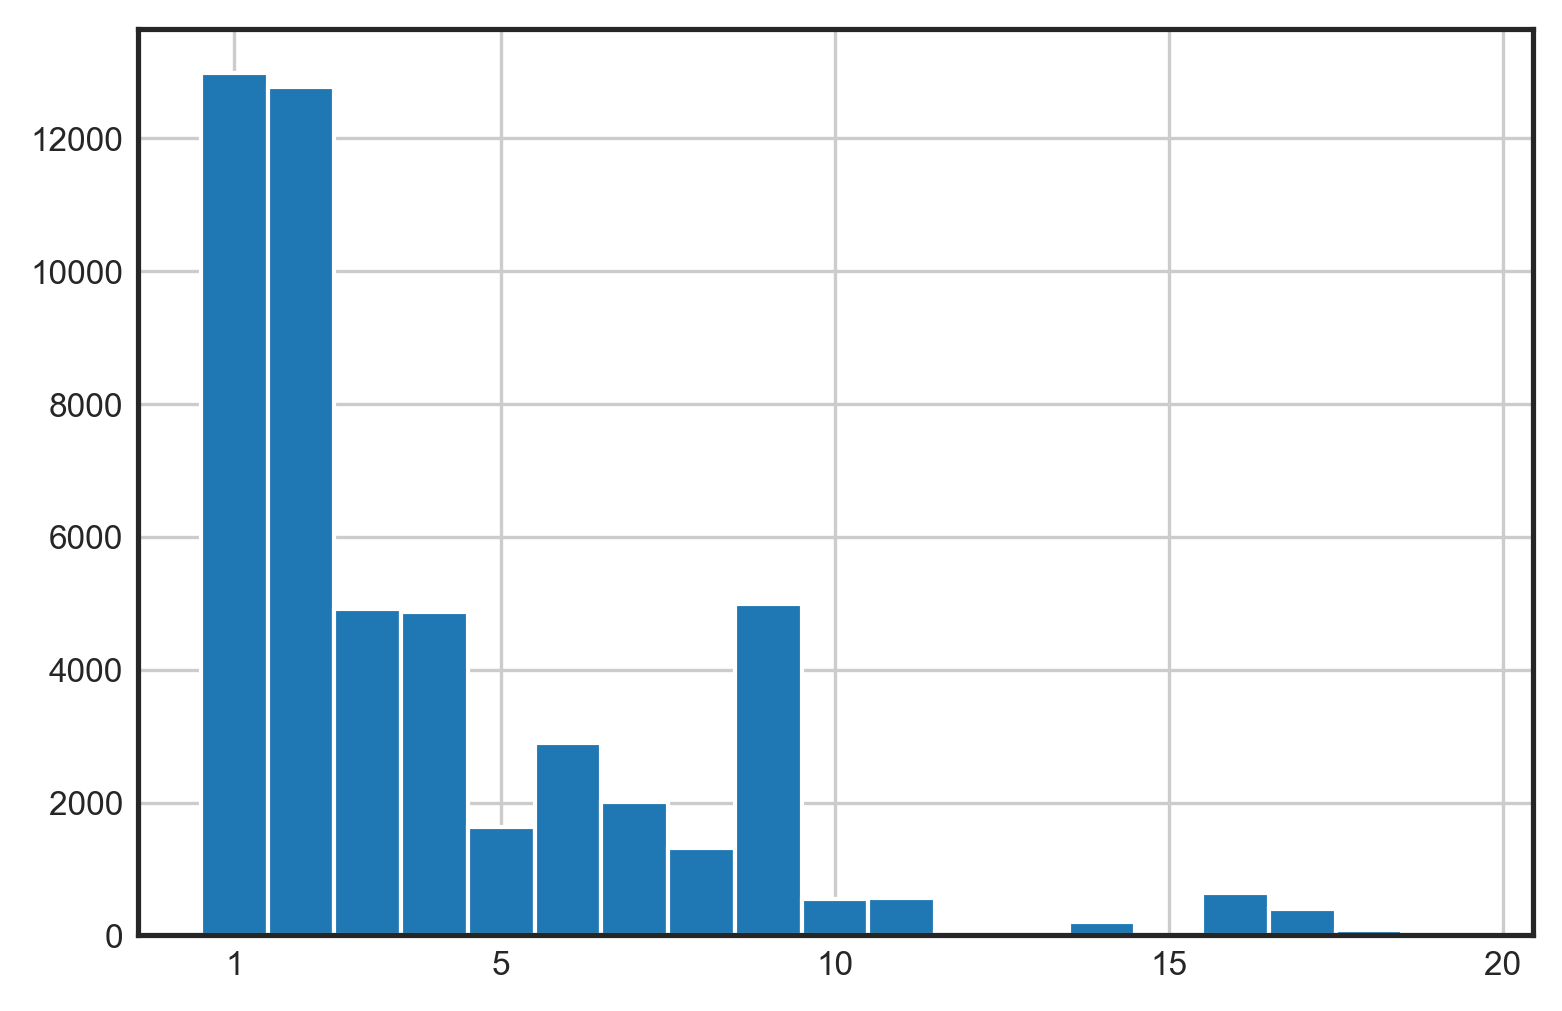

In [7]:
fig,ax=plt.subplots()
duration.hist(bins=[n+0.5 for n in range(0,20)],ax=ax)
ax.set_xticks([1,5,10,15,20])

In [8]:
# averigng post quem and ante quem
coins["date_avr"] = coins.apply(lambda row: (row["not_before"] + row["not_after"]) / 2, axis=1).round()

<AxesSubplot:xlabel='date_avr', ylabel='Density'>

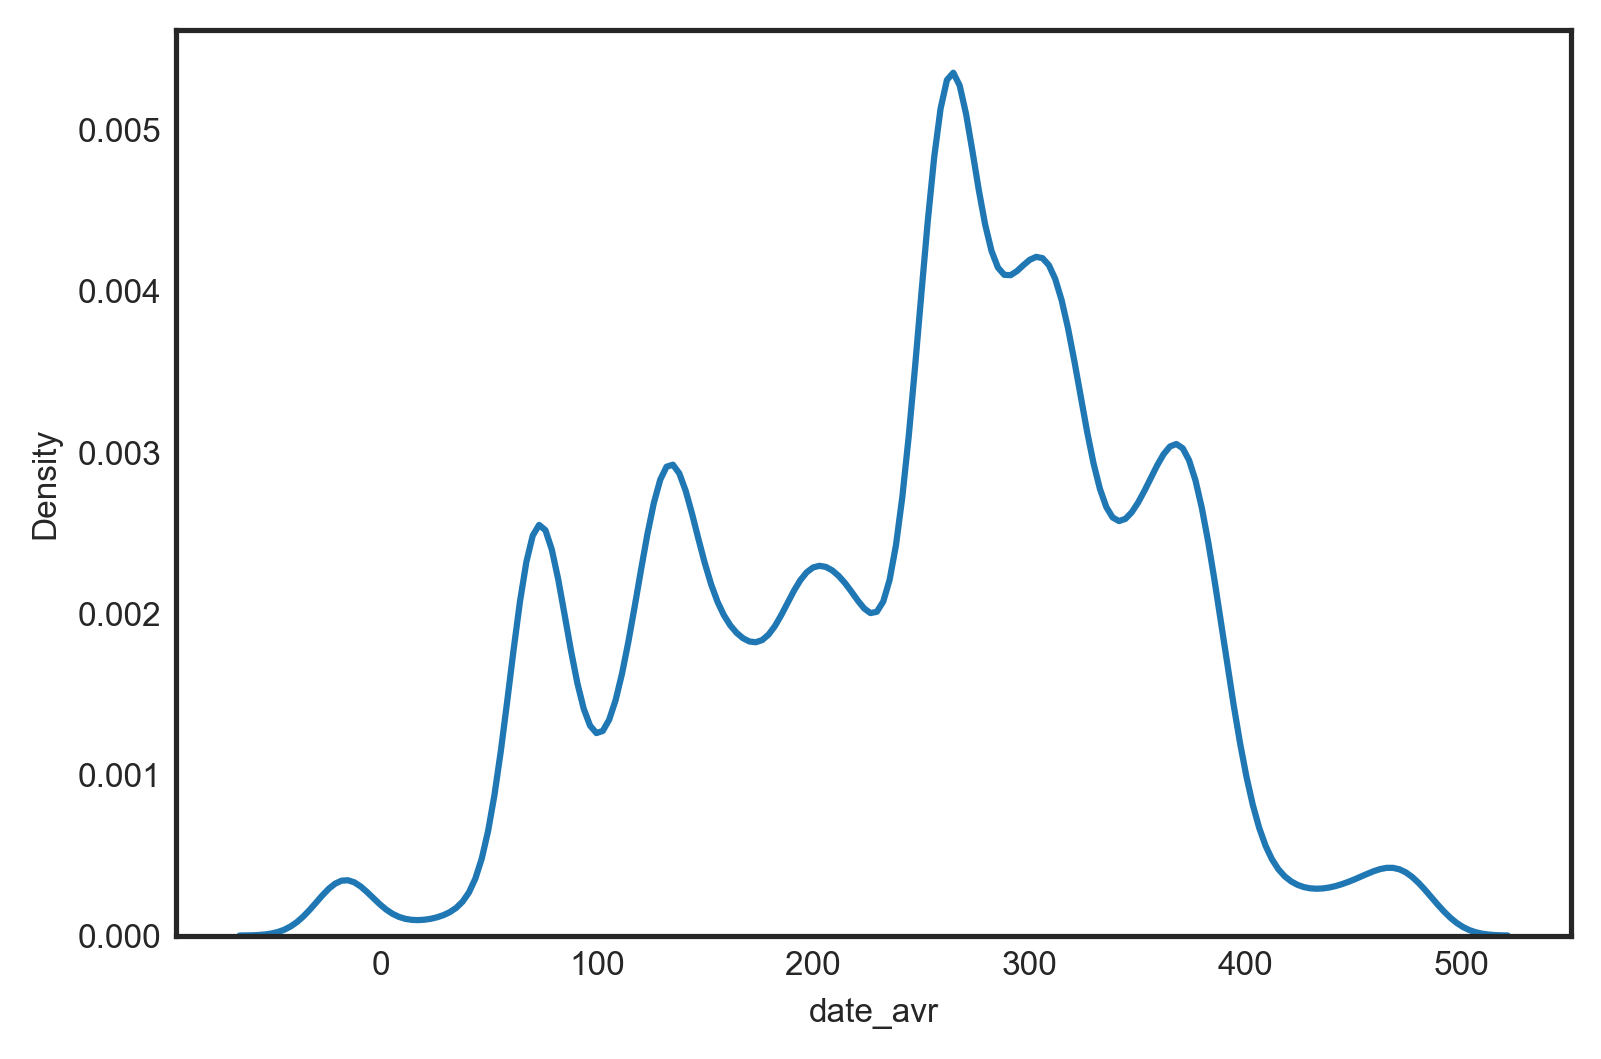

In [9]:
# plot overall temporal distribution by means of a KDE plot
sns.kdeplot(coins["date_avr"])

In [10]:
test_dates = coins["date_avr"].tolist()[:1000]
test_dates[:20]

[311.0,
 246.0,
 390.0,
 338.0,
 211.0,
 313.0,
 80.0,
 290.0,
 310.0,
 272.0,
 380.0,
 193.0,
 334.0,
 279.0,
 366.0,
 137.0,
 318.0,
 164.0,
 108.0,
 318.0]

In [11]:
n = 246
buffer = 10

In [12]:
[d for d in test_dates if n-(buffer/2) <= d <= n+(buffer/2)][:20]

[246.0,
 250.0,
 250.0,
 244.0,
 249.0,
 248.0,
 249.0,
 250.0,
 250.0,
 251.0,
 251.0,
 250.0,
 249.0,
 241.0,
 246.0,
 246.0,
 242.0,
 250.0,
 248.0,
 246.0]

In [13]:
# function to count all types within a buffer (aka moving average)
def get_moving_avr(dates_data, buffer=10):
    diff = int(buffer / 2)
    dates_data = list(dates_data)
    date_min = int(np.nanmin(dates_data))
    date_max = int(np.nanmax(dates_data))
    #return date_max
    dates = [n for n in range(date_min + diff, date_max - diff)]
    counts = []
    for n in dates:
        counts.append((len([d for d in dates_data if n-diff <= d <= n+diff])))
    return dates, counts

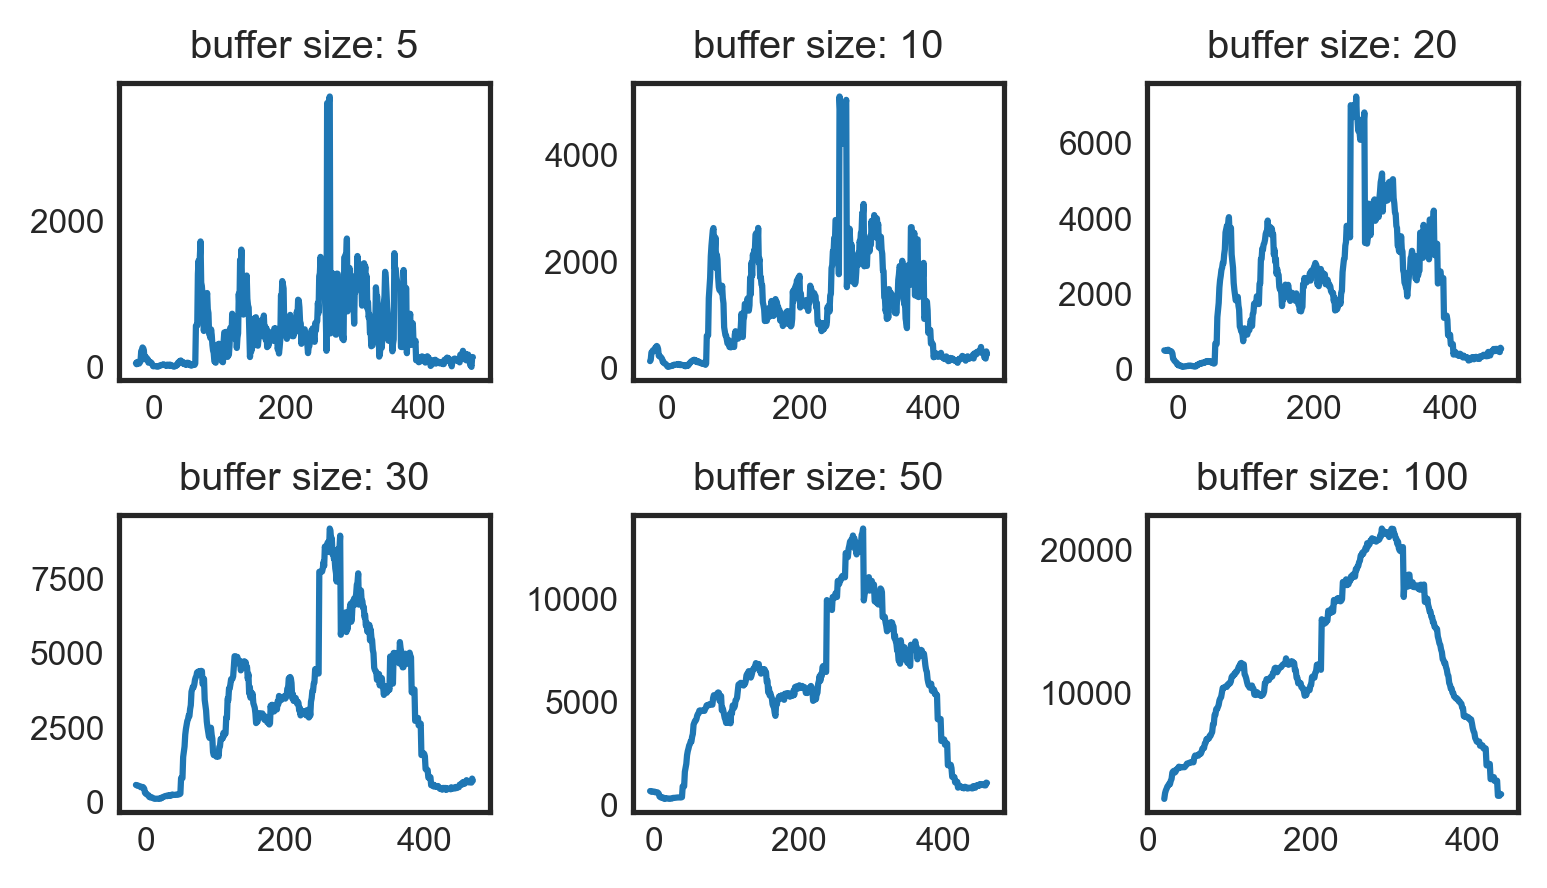

In [14]:
# plots of temporal distributions with different buffer sizes
buffer_sizes = [5, 10, 20, 30, 50, 100]

fig, axs = plt.subplots(2,3, figsize=(5.2, 3), dpi=300, tight_layout=True)
for buffer, ax in zip(buffer_sizes, axs.ravel()):
    moving_avr_data = get_moving_avr(coins["date_avr"], buffer)
    ax.plot(moving_avr_data[0], moving_avr_data[1])
    ax.set_title("buffer size: " + str(buffer))

In [15]:
len(coins)

51311

In [16]:
coins

,@id,@type,ontology#hasAuthority,ontology#hasDenomination,ontology#hasEndDate,ontology#hasManufacture,ontology#hasMaterial,ontology#hasMint,@id_obverse,ontology#hasRegion,...,ontology#hasLegend_obverse,ontology#hasPortrait_obverse,description_obverse,ontology#hasLegend_reverse,ontology#hasPortrait_reverse,description_reverse,ontology#hasControlmark_reverse,not_before,not_after,date_avr
0,http://numismatics.org/ocre/id/ric.6.sis.221,"[http://www.w3.org/2004/02/skos/core#Concept, ...",licinius,ae2,0311-01-01,struck,ae,siscia,ric.6.sis.221#obverse,pannonia,...,DIVO GAL VAL MAXIMIANO,galerius,"Head of Galerius, veiled, right",FORTI FOR-TVNAE,58260,"Fortuna, draped, standing left by wheel, holdi...",None,311.0,311.0,311.0
1,http://numismatics.org/ocre/id/ric.4.ph_i.28A,"[http://www.w3.org/2004/02/skos/core#Concept, ...",philip_the_arab,aureus,0247-01-01,struck,av,rome,ric.4.ph_i.28A#obverse,italy,...,IMP M IVL PHILIPPVS AVG,philip_the_arab,"Bust of Philip the Arab, laureate, draped, cui...",ANNONA AVGG,nomisma.rdf,"Annona, draped, standing left, holding corn-ea...",None,244.0,247.0,246.0
2,http://numismatics.org/ocre/id/ric.9.tri.96B.2,"[http://nomisma.org/ontology#TypeSeriesItem, h...",valentinian_ii,ae3,0392-01-01,struck,ae,treveri,ric.9.tri.96B.2#obverse,gallia,...,D N THEODO-SIVS P F AVG,theodosius_i,"Bust of Theodosius I, pearl-diademed, draped a...",GLORIA RO-MANORVM,,"Emperor advancing right, dragging captive with...",None,388.0,392.0,390.0
3,http://numismatics.org/ocre/id/ric.8.aq.3,"[http://www.w3.org/2004/02/skos/core#Concept, ...",constantine_ii,multiple-gold,0340-01-01,struck,av,aquileia,ric.8.aq.3#obverse,italy,...,FL IVL CONS-TANS P F AVG,constans,"Bust of Constans, laureate, rosette-diademed, ...",VIRTVS - CONSTANTIS AVG,constans,"Constans, draped, cuirassed, standing front, h...",None,337.0,340.0,338.0
4,http://numismatics.org/ocre/id/ric.4.crl.191,"[http://www.w3.org/2004/02/skos/core#Concept, ...",caracalla,denarius,0211-01-01,struck,ar,rome,ric.4.crl.191#obverse,italy,...,ANTONINVS PIVS AVG BRIT,caracalla,"Head of Caracalla, laureate, right",PONTIF TR P XIIII COS III,80685,"Virtus, helmeted, draped, standing right, left...",None,211.0,211.0,211.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51306,http://numismatics.org/ocre/id/ric.5.gall(2).5...,"[http://www.w3.org/2004/02/skos/core#Concept, ...",gallienus,antoninianus,0268-01-01,struck,ar,siscia,ric.5.gall(2).580kA.3#obverse,pannonia,...,GALLIENVS AVG,gallienus,"Head of Gallienus, radiate, right",PROVI AVG,59843,"Providentia, draped, standing left, holding ba...",None,260.0,268.0,264.0
51307,http://numismatics.org/ocre/id/ric.4.ca.20A,"[http://nomisma.org/ontology#TypeSeriesItem, h...",clodius_albinus,denarius,0197-01-01,struck,ar,lugdunum,ric.4.ca.20A#obverse,gallia,...,IMP CAE D CLO SEP ALB AVG,clodius_albinus,"Head of Clodius Albinus, laureate, right",FIDES AVG COS II,,"Clasped right hands, holding legion eagle",None,195.0,197.0,196.0
51308,http://numismatics.org/ocre/id/ric.6.aq.53,"[http://nomisma.org/ontology#TypeSeriesItem, h...",constantius_chlorus,aureus,0306-01-01,struck,av,aquileia,ric.6.aq.53#obverse,italy,...,SEVERVS NOB CAES,severus_ii,"Head of Severus II, laureate, right",FELICITAS SAECVLI CAESS NN,60915,CAES,None,305.0,306.0,306.0
51309,http://numismatics.org/ocre/id/ric.2_3(2).hdn....,"[http://www.w3.org/2004/02/skos/core#Concept, ...",hadrian,dupondius,0130-01-01,struck,ae,rome,ric.2_3(2).hdn.1150-1152#obverse,italy,...,HADRIANVS AVGVSTVS,hadrian,,S C (in field),178090,"Indulgentia seated left, extending hand and ho...",None,129.0,130.0,130.0


In [17]:
coins.groupby("ontology#hasDenomination").size().sort_values(ascending=False)


ontology#hasDenomination
antoninianus                           9463
denarius                               6982
sestertius                             5288
aureus                                 4613
ae3                                    3827
                                       ... 
_:N5a55ce70f90c405eb593b98c5ca2ae7c       1
_:N5a6bd67d264a48b6aa739e543ecbe3f8       1
_:N5a9e68573c654a528eff2b7d3aa12f6c       1
_:N5abc1909227045f194f1a7c15db09a05       1
_:N84d1a95d118245ba91c9f57ece93f151       1
Length: 3117, dtype: int64

In [18]:
cointypes = coins.groupby("ontology#hasDenomination").size().sort_values(ascending=False).index.tolist()
cointypes[:30]

['antoninianus',
 'denarius',
 'sestertius',
 'aureus',
 'ae3',
 'as',
 'dupondius',
 'solidus',
 'ae1',
 'ae2',
 'ae4',
 'siliqua',
 'quinarius',
 'large_ae2',
 'uncertain_value',
 '',
 'tremissis',
 'quinarius_aureus',
 'light_miliarensis',
 'multiple-gold',
 'quadrans',
 'semis',
 'small_ae2',
 'reduced_ae2',
 'semissis',
 'fraction',
 'heavy_miliarensis',
 'cistophorus',
 'half_siliqua',
 'reduced_siliqua']

In [19]:
cointypes = ['antoninianus', 'denarius', 'sestertius', 'aureus', 'as', 'dupondius', 'solidus', 'quinarius', 'quinarius_aureus']
cointypes

['antoninianus',
 'denarius',
 'sestertius',
 'aureus',
 'as',
 'dupondius',
 'solidus',
 'quinarius',
 'quinarius_aureus']

In [20]:
# how many denaries do we have?
coins = coins[coins["ontology#hasDenomination"].isin(cointypes)].copy()

In [21]:
len(coins)

34931

In [22]:
authorities_all_coins = coins.groupby("ontology#hasAuthority").size().sort_values(ascending=False)
authorities_all_coins

ontology#hasAuthority
gallienus            4184
hadrian              3472
antoninus_pius       2363
marcus_aurelius      1807
septimius_severus    1723
                     ... 
aureolus                2
zenobia                 2
saturninus              1
olybrius                1
domitian_ii             1
Length: 126, dtype: int64

In [23]:
coins.head(20)

,@id,@type,ontology#hasAuthority,ontology#hasDenomination,ontology#hasEndDate,ontology#hasManufacture,ontology#hasMaterial,ontology#hasMint,@id_obverse,ontology#hasRegion,...,ontology#hasLegend_obverse,ontology#hasPortrait_obverse,description_obverse,ontology#hasLegend_reverse,ontology#hasPortrait_reverse,description_reverse,ontology#hasControlmark_reverse,not_before,not_after,date_avr
1,http://numismatics.org/ocre/id/ric.4.ph_i.28A,"[http://www.w3.org/2004/02/skos/core#Concept, ...",philip_the_arab,aureus,0247-01-01,struck,av,rome,ric.4.ph_i.28A#obverse,italy,...,IMP M IVL PHILIPPVS AVG,philip_the_arab,"Bust of Philip the Arab, laureate, draped, cui...",ANNONA AVGG,nomisma.rdf,"Annona, draped, standing left, holding corn-ea...",None,244.0,247.0,246.0
4,http://numismatics.org/ocre/id/ric.4.crl.191,"[http://www.w3.org/2004/02/skos/core#Concept, ...",caracalla,denarius,0211-01-01,struck,ar,rome,ric.4.crl.191#obverse,italy,...,ANTONINVS PIVS AVG BRIT,caracalla,"Head of Caracalla, laureate, right",PONTIF TR P XIIII COS III,80685,"Virtus, helmeted, draped, standing right, left...",None,211.0,211.0,211.0
5,http://numismatics.org/ocre/id/ric.7.ar.2,"[http://nomisma.org/ontology#TypeSeriesItem, h...",constantine_i,solidus,0313-01-01,struck,av,arelate,ric.7.ar.2#obverse,gallia,...,LICINI-VS P F AVG,licinius,"Head of Licinius, laureate, right",PRINCIPIS PRO-VIDENTISSIMI,,"TIA; on ground to left, helmet; on ground to r...",None,313.0,313.0,313.0
6,http://numismatics.org/ocre/id/ric.2_1(2).tit.288,"[http://nomisma.org/ontology#TypeSeriesItem, h...",titus,sestertius,0081-01-01,struck,ae,rome,ric.2_1(2).tit.288#obverse,italy,...,CAES DIVI AVG VESP F DOMITIANVS COS VII,domitian,"Head of Domitian, laureate, right",PAX AVGVST S C,76227,"Pax standing left, holding branch and cornucopiae",None,80.0,81.0,80.0
7,http://numismatics.org/ocre/id/ric.5.cara.745,"[http://nomisma.org/ontology#TypeSeriesItem, h...",carausius,antoninianus,0293-01-01,struck,ar,uncertain_value,ric.5.cara.745#obverse,britannia,...,IMP CARAVSIV,carausius,"Bust of Carausius, radiate, draped, right",COMES AVG,57060,"Minerva, helmeted, draped, standing left, hold...",None,286.0,293.0,290.0
8,http://numismatics.org/ocre/id/ric.6.anch.128,"[http://nomisma.org/ontology#TypeSeriesItem, h...",maximinus_daia,aureus,0311-01-01,struck,av,antiocheia_syria,ric.6.anch.128#obverse,syria,...,MAXIMIANVS AVGVSTVS,galerius,"Head of Galerius, laureate, right",CONSVL VIII - P P PROCOS,galerius,"Galerius, laureate, togate, standing front, he...",None,310.0,311.0,310.0
9,http://numismatics.org/ocre/id/ric.5.aur.45,"[http://nomisma.org/ontology#TypeSeriesItem, h...",aurelian,antoninianus,0275-01-01,struck,ar,rome,ric.5.aur.45#obverse,italy,...,IMP AVRELIANVS AVG,aurelian,"Bust of Aurelian, radiate, cuirassed, right",AEQVITAS AVGG,85985,"Aequitas, draped, standing right, holding scal...",None,270.0,275.0,272.0
13,http://numismatics.org/ocre/id/ric.5.pro.29,"[http://www.w3.org/2004/02/skos/core#Concept, ...",probus,antoninianus,0282-01-01,struck,ar,lugdunum,ric.5.pro.29#obverse,gallia,...,IMP C PROBVS P F AVG,probus,"Bust of Probus, radiate, cuirassed, right",FIDES MILITVM,69305,"Fides, draped, standing left, holding ensign i...",None,276.0,282.0,279.0
15,http://numismatics.org/ocre/id/ric.2_3(2).hdn....,"[http://www.w3.org/2004/02/skos/core#Concept, ...",hadrian,dupondius,0137-01-01,struck,ae,rome,ric.2_3(2).hdn.2680#obverse,italy,...,L AELIVS CAESAR,lucius_aelius,"Head of Lucius Aelius Caesar, right",S C (in field),58668,"Salus seated left, holding patera and with elb...",None,137.0,137.0,137.0
17,http://numismatics.org/ocre/id/ric.3.m_aur.1397,"[http://nomisma.org/ontology#TypeSeriesItem, h...",marcus_aurelius,sestertius,0164-01-01,struck,ae,rome,ric.3.m_aur.1397#obverse,italy,...,L AVREL VERVS AVG ARMENIACVS,nomisma.rdf,"Head of Lucius Verus, laureate, right",TR P IIII IMP II COS II S C,60915,"Victory, winged, half-draped, standing right, ...",None,163.0,164.0,164.0


# exploring description_reverse

In [27]:
ocre_deities = pd.read_csv("../data/coin_ocre_deities.csv")
ocre_deities

,Name
0,Abundantia
1,Achaea
2,Aeneas
3,Aequitas
4,Aeternitas
...,...
195,Vesta
196,Via Trajana
197,Victory
198,Virtus


In [26]:
deities_dict = {}
for deity_raw in ocre_deities["Name"].tolist():
    deity_list = deity_raw.replace(" (", "/").split("/")
    for deity_form in deity_list:
        deities_dict[deity_form] = deity_list[0]

# manual corrections:
deities_dict["Nike"] = "Victory"
deities_dict["Victoria"] = "Victory"

deities_tups = list(deities_dict.items())
deities_tups = sorted(deities_tups, key = lambda x: len(x[0]), reverse=True)
deities_tups[:10]

[('Genius of the Senate', 'Genius of the Senate'),
 ('Saeculum Frugiferum', 'Saeculum Frugiferum'),
 ('Genius of Lugdunum', 'Genius of Lugdunum'),
 ('Constantinopolis', 'Constantinopolis'),
 ('Fortuna Victrix', 'Fortuna Victrix'),
 ('Valeria Luperca', 'Valeria Luperca'),
 ('Diana Lucifera', 'Diana Lucifera'),
 ('Diana of Perge', 'Diana of Perge'),
 ('Bonus Eventus', 'Bonus Eventus'),
 ('Dea Caelestis', 'Dea Caelestis')]

In [28]:
test1 = "Fortuna, draped, standing left by wheel, holding rudder on globe in right hand and cornucopiae in left hand"
test2 = "Salus seated left, holding patera and with elbow rarely on Spes statue; to left, altar with snake coiled around"
test3 = "Ceres, right, veiled and draped, seated left, holding corn-ears and torch, facing Annona, draped, standing right, right hand resting on hip, left holding cornucopiae; in center, modius on garlanded altar right; behind, ship's stern"
test4 = "Annona standing, left, holding statue of Aequitas and cornucopiae; modius with corn-ears left; prow right"
test5 = "Annona, draped, standing left, holding statuette (of Concordia?) in right hand and cornucopiae in left hand; to left and right, modius with corn ears and ship, on which are two figures and Victory"

In [29]:
def extract_deities(description):
    deities_found = []
    for tup in deities_tups:
        if tup[0] in description:
            if len(re.findall("(\W|^)" + tup[0] + "(\W|$)", description)) > 0:
                deities_found.append(tup[1])
                description = re.sub("(\W|^)(" + tup[0] + ")(\W|$)", r"\1", description)
    return deities_found

In [30]:
extract_deities(test3)

['Annona', 'Ceres']

In [31]:
# extract entities (e.g. Fortuna etc.) from "description_reverse"
coins["deities"] = coins["description_reverse"].apply(extract_deities)

In [32]:
deities_freqs = nltk.FreqDist([d for l in coins["deities"] for d in l])
deities_freqs.most_common(20)

[('Victory', 5375),
 ('Jupiter', 1361),
 ('Pax', 1326),
 ('Mars', 1317),
 ('Roma', 1286),
 ('Fortuna', 1110),
 ('Felicitas', 972),
 ('Providentia', 928),
 ('Concordia', 895),
 ('Salus', 839),
 ('Minerva', 832),
 ('Sol', 790),
 ('Liberalitas', 675),
 ('Aequitas', 613),
 ('Spes', 612),
 ('Hercules', 560),
 ('Pietas', 554),
 ('Fides', 534),
 ('Genius', 484),
 ('Securitas', 480)]

In [33]:
deities_freqs_df = pd.DataFrame(deities_freqs.most_common())

In [34]:
deities_freqs_df.to_csv("../data/deities_freqs_df.csv")

In [35]:
coins.to_csv("../data/coins_deities_df.csv")
coins.to_parquet("../data/coins_deities_df.parquet")